In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import zipfile
import os
import cv2
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd

In [4]:
X_train=[]
classes = os.listdir('/content/drive/MyDrive/duck_chicken/train')
for cat in classes:
  for img in os.listdir('/content/drive/MyDrive/duck_chicken/train/'+cat):
    try:
      X_train.append(cv2.resize(cv2.imread('/content/drive/MyDrive/duck_chicken/train/'+cat+'/'+img),(224,224)))
    except:
      continue


In [5]:
classes

['chicken', 'duck']

In [6]:
X_test=[]
classes = os.listdir('/content/drive/MyDrive/duck_chicken/test')
for cat in classes:
  for img in os.listdir('/content/drive/MyDrive/duck_chicken/test/'+cat):
    try:
      X_test.append(cv2.resize(cv2.imread('/content/drive/MyDrive/duck_chicken/test/'+cat+'/'+img),(224,224)))
    except:
      continue

In [7]:
X_val=[]
classes = os.listdir('/content/drive/MyDrive/duck_chicken/val')
for cat in classes:
  for img in os.listdir('/content/drive/MyDrive/duck_chicken/val/'+cat):
    try:
      X_val.append(cv2.resize(cv2.imread('/content/drive/MyDrive/duck_chicken/val/'+cat+'/'+img),(224,224)))
    except:
      continue

In [8]:
X_train_arr = np.array(X_train)/255.0
X_test_arr = np.array(X_test)/255.0
X_val_arr = np.array(X_val)/255.0

In [9]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory('/content/drive/MyDrive/duck_chicken/train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory('/content/drive/MyDrive/duck_chicken/test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

val_set = val_datagen.flow_from_directory('/content/drive/MyDrive/duck_chicken/val',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 128 images belonging to 2 classes.
Found 40 images belonging to 2 classes.
Found 32 images belonging to 2 classes.


In [10]:
vgg = VGG19(input_shape=(224,224,3), weights='imagenet', include_top=False)
#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False
x = Flatten()(vgg.output)

prediction = Dense(2, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)
model.summary()

80134624/80134624 [==============================] - 4s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [11]:
model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

In [12]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#Early stopping to avoid overfitting of model

In [13]:
y_train=training_set.classes
y_test=test_set.classes
y_val=val_set.classes

In [14]:
# fit the model
history = model.fit(
  X_train_arr,
  y_train,
  validation_data=(X_val_arr,y_val),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
4/4 [==============================] - 10s 444ms/step - loss: 1.5641 - accuracy: 0.5234 - val_loss: 2.2932 - val_accuracy: 0.5000
Epoch 2/10
4/4 [==============================] - 1s 216ms/step - loss: 1.3734 - accuracy: 0.5469 - val_loss: 1.4121 - val_accuracy: 0.5000
Epoch 3/10
4/4 [==============================] - 1s 270ms/step - loss: 0.7421 - accuracy: 0.6016 - val_loss: 0.7407 - val_accuracy: 0.5312
Epoch 4/10
4/4 [==============================] - 1s 217ms/step - loss: 0.5228 - accuracy: 0.7500 - val_loss: 0.3910 - val_accuracy: 0.8125
Epoch 5/10
4/4 [==============================] - 1s 273ms/step - loss: 0.3061 - accuracy: 0.8516 - val_loss: 0.4628 - val_accuracy: 0.7188
Epoch 6/10
4/4 [==============================] - 1s 201ms/step - loss: 0.1575 - accuracy: 0.9609 - val_loss: 0.4299 - val_accuracy: 0.8125
Epoch 7/10
4/4 [==============================] - 1s 195ms/step - loss: 0.1628 - accuracy: 0.9297 - val_loss: 0.3185 - val_accuracy: 0.8750
Epoch 8/10
4/4 [===

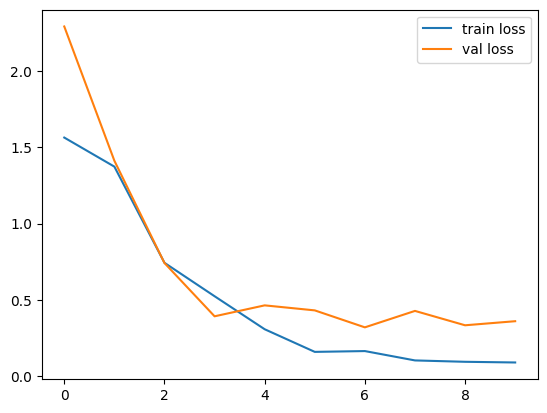

In [15]:
# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()

plt.savefig('vgg-loss-rps-1.png')
plt.show()

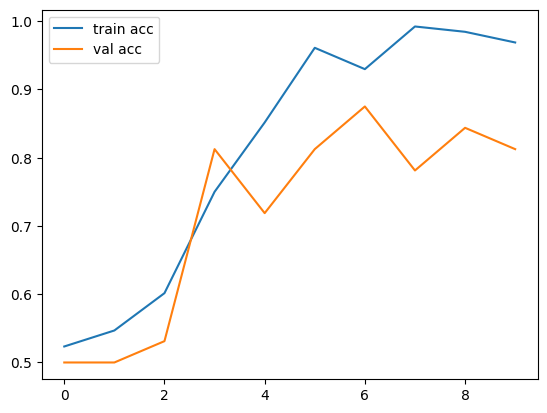

In [16]:
# accuracies
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()

plt.savefig('vgg-acc-rps-1.png')
plt.show()

In [17]:
model.evaluate(X_test_arr,y_test,batch_size=32)

2/2 [==============================] - 3s 2s/step - loss: 0.2467 - accuracy: 0.9250


[0.2466963827610016, 0.925000011920929]

In [18]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

In [19]:
y_pred=model.predict(X_test_arr)
y_pred=np.argmax(y_pred,axis=1)

2/2 [==============================] - 0s 193ms/step


In [20]:
accuracy_score(y_pred,y_test)

0.925

In [21]:

print(classification_report(y_pred,y_test))

              precision    recall  f1-score   support

           0       0.90      0.95      0.92        19
           1       0.95      0.90      0.93        21

    accuracy                           0.93        40
   macro avg       0.93      0.93      0.92        40
weighted avg       0.93      0.93      0.93        40



In [22]:
y_test_word =[]
for i in y_test:
  if i==0:
    y_test_word.append('chicken')
  else:
    y_test_word.append('duck')

y_pred_word =[]
for i in y_pred:
  if i==0:
    y_pred_word.append('chicken')
  else:
    y_pred_word.append('duck')

Text(0.5, 1.0, 'Actual Label:chicken, Predicted Label:duck')

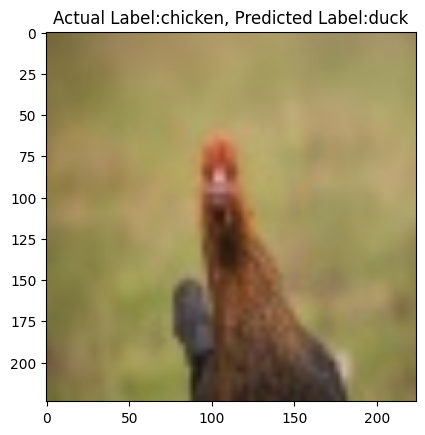

In [23]:
plt.imshow(cv2.cvtColor(X_test[0], cv2.COLOR_BGR2RGB))
plt.title(f'Actual Label:{y_test_word[0]}, Predicted Label:{y_pred_word[0]}')

Text(0.5, 1.0, 'Actual Label:chicken, Predicted Label:chicken')

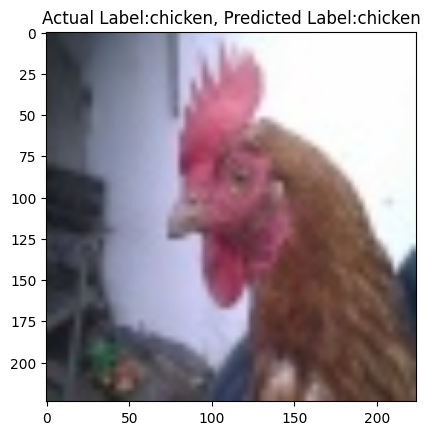

In [24]:
plt.imshow(cv2.cvtColor(X_test[5], cv2.COLOR_BGR2RGB))
plt.title(f'Actual Label:{y_test_word[5]}, Predicted Label:{y_pred_word[5]}')

Text(0.5, 1.0, 'Actual Label:duck, Predicted Label:duck')

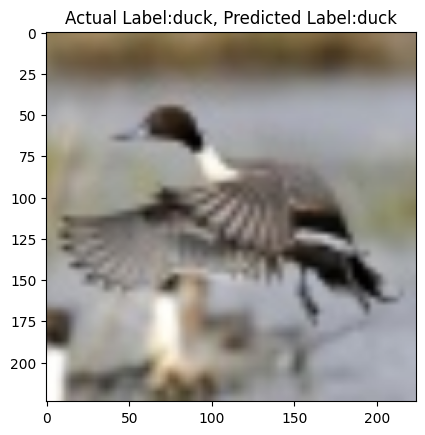

In [29]:
plt.imshow(cv2.cvtColor(X_test[31], cv2.COLOR_BGR2RGB))
plt.title(f'Actual Label:{y_test_word[31]}, Predicted Label:{y_pred_word[31]}')